# Tensor Fusion Network w/ Decomposition & Cox Survival Analysis

## Initial Imports

In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import sys
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import argparse
import time
import tensorly as tl
import tensorly
from decompositions import cp_decomposition_conv_layer, tucker_decomposition_conv_layer

from torch.utils.data import Dataset, DataLoader, random_split

from torch.nn.utils.rnn import pad_sequence

import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.utils.rnn as rnn_utils
from torchvision.io import read_image
from PIL import Image
import glob
import os

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

import pandas as pd
import numpy as np
from glob import glob
import os, os.path
import matplotlib.pyplot as plt
from numpy import asarray

import sklearn.metrics
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_gbsg2
# from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score

import itertools
from itertools import *

import datetime
import pickle

import torchtuples as tt
from pycox.models import CoxCC
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

from ptflops import get_model_complexity_info
import torchprofile

#### Apply Configuration Changes

In [2]:
torch.autograd.detect_anomaly(True)

/tmp/ipykernel_5255/131645128.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly(True)


## Determine Compute Device

In [3]:
# Use GPU if possible
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# ^ Usually cuda:0, but at time of writing all avaliable memory on GPU 0 is in use.

# Use PyTorch as Tensorly Backend
tl.set_backend('pytorch')

# Force CPU Evaluation (Not Recommended)
# device = torch.device("cpu")

# Utility Functions

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def calculate_flop(net):
    macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True, backend='aten', \
                                             print_per_layer_stat=False, verbose=False)
    flops = macs[:-5]
    flops = float(flops)
    flops = flops * 2
    
    flops = str(flops)
    flops = flops + " FLOP"
    
    print('{:<30}  {:<8}'.format('Computational Complexity: ', macs))
    print('{:<30}  {:<8}'.format('Approximate FLOP: ', flops))
    # print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    
    return macs

# Declare TFN Constants

In [5]:
AUTOENCODER_INPUTS = 6

## Import Data

### Deserialize MIMIC-IV Dataset

In [6]:
pd.options.display.max_columns = None

mimic_df = pd.read_pickle("Preprocessed_MIMIC.pkl")

# Drop patients that don't have any demographic info.
mimic_df = mimic_df.dropna(subset = ['gender'])
mimic_df = mimic_df.dropna(subset = ['anchor_age'])
mimic_df = mimic_df.dropna(subset = ['hospital_expire_flag'])

mimic_df

# mimic_df.loc[mimic_df['hospital_expire_flag'] == 1.0]

# mimic_df_ethnicity = mimic_df['ethnicity'].tolist()
# mimic_df_ethnicity

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit
0,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,21800723,80556.875,/data/datasets/resized/68b5c4b1-227d0485-9cc38...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,J449,10.0,"Chronic obstructive pulmonary disease, unspeci...",NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0.0,F,52.0,2180.0,2014 - 2016,NaN,39553978.0,admit,Medical Intensive Care Unit (MICU)
1,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,10000980,51967283,CHEST (PORTABLE AP),AP,21890627,64348.484,/data/datasets/resized/943486a3-b3fa9ff7-50f5a...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26913865.0,39765666.0,2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,I5023,10.0,Acute on chronic systolic (congestive) heart f...,0044,9.0,Procedure on vessel bifurcation,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0.0,F,73.0,2186.0,2008 - 2010,NaN,39765666.0,admit,Medical Intensive Care Unit (MICU)
2,06c9ad0d-eba8bb4c-7f1216e8-3164684d-4a4b228d,10002428,56100138,CHEST (PA AND LAT),AP,21560412,123723.656,/data/datasets/resized/06c9ad0d-eba8bb4c-7f121...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225.0,33987268.0,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU)
5,08ee3bce-a3ed7087-0af8769d-de0d3535-1318d234,10002428,58838312,CHEST (PORTABLE AP),AP,21560430,190712.031,/data/datasets/resized/08ee3bce-a3ed7087-0af87...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,20321825.0,34807493.0,2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,E874,10.0,Mixed disorder of acid-base balance,9390,9.0,Non-invasive mechanical ventilation,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-30 18:30:00,2156-04-30 21:53:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,34807493.0,admit,Medical Intensive Care Unit (MICU)
6,cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99,10002428,59015983,CHEST (PORTABLE AP),AP,21560412,153744.828,/data/datasets/resized/cc0b5db2-cc391879-a10b0...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225.0,33987268.0,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20150,fb10d1e3-8298d0a7-94438c16-66607b23-27127377,19998330,59694089,CHEST (PORTABLE AP),AP,21780920,180917.656,/data/datasets/resized/fb10d1e3-8298d0a7-94438...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,23151993.0,31085771.0,2178-09-20 21:40:00,2178-09-21 18:06:26,0.851690,N183,10.0,"Chronic kidney disease, sta

## View Histograms of Data

Used to help determine the categories for one-hot encoding.

array([[<Axes: title={'center': 'anchor_age'}>]], dtype=object)

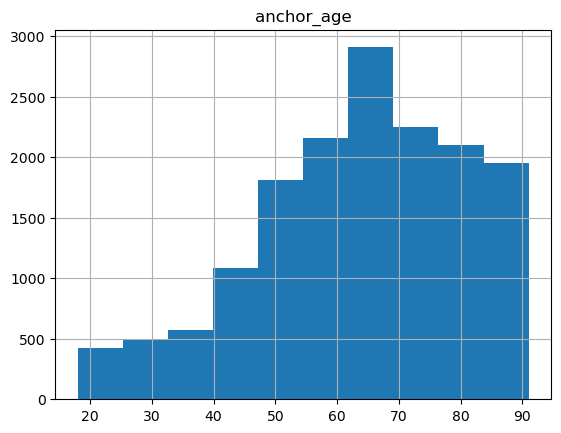

In [7]:
mimic_df.hist(column=["anchor_age"], legend=False)

## Preprocess Demographics into one-hot encoding for model.
### Define Function to convert demographics to one-hot encoding.

In [8]:
def one_hot_demographics(row):
        # Build each category and concat to this list.
        one_hot_demographics = []
        
        row_age = row['anchor_age']
        # Convert Age to One Hot Categories.
        # Categories are NaN, 0-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81-90, 90+
        if (row_age < 20.0):
            age_hot = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        elif (row_age < 30.0):
            age_hot = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        elif (row_age < 40.0):
            age_hot = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
        elif (row_age < 50.0):
            age_hot = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        elif (row_age < 60.0):
            age_hot = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
        elif (row_age < 70.0):
            age_hot = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        elif (row_age < 80.0):
            age_hot = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
        elif (row_age < 90.0):
            age_hot = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
        elif (row_age >= 91.0):
            age_hot = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        else:
            age_hot = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            print("Failover condition for age encoding!")
            
        # Convert Gender to one-hot encoding.
        
        row_gender = row['gender']
        if (row_gender == 'F'):
            gender_hot = [1, 0, 0]
        elif (row_gender == 'M'):
            gender_hot = [0, 1, 0]
        else:
            gender_hot = [0, 0, 1]
            print("Failover condition for gender encoding!")
            
        row_marital = row['marital_status']
        # Convert Marital Status to one-hot encoding.
        if (row_marital == 'MARRIED'):
            marital_hot = [1, 0, 0]
        elif (row_marital == 'SINGLE'):
            marital_hot = [0, 1, 0]
        else:
            marital_hot = [0, 0, 1] # Capture all other marital states.
        
        row_ethnicity = row['ethnicity']
        # Convert Ethnicity to one-hot encoding.
        # Categories: White, African-American, Hispanic, Asian, Other
        if (row_ethnicity == 'WHITE'):
            ethnicity_hot = [1, 0, 0, 0, 0]
        elif (row_ethnicity == 'BLACK/AFRICAN AMERICAN'):
            ethnicity_hot = [0, 1, 0, 0, 0]
        elif (row_ethnicity == 'HISPANIC/LATINO'):
            ethnicity_hot = [0, 0, 1, 0, 0]
        elif (row_ethnicity == 'ASIAN'):
            ethnicity_hot = [0, 0, 0, 1, 0]
        else:
            ethnicity_hot = [0, 0, 0, 0, 1]
        
        # Append the one hot encoding to one list, convert to tensor, and return.
        one_hot_demographics.extend(age_hot)
        one_hot_demographics.extend(gender_hot)
        one_hot_demographics.extend(marital_hot)
        one_hot_demographics.extend(ethnicity_hot)
        
        return one_hot_demographics

### Iterate over each row of the Panda, encode to one-hot, and append as new column.

In [9]:
demographics_one_hot = mimic_df.apply(one_hot_demographics, axis=1)
demographics_one_hot.name = 'one_hot'
# demographics_one_hot

mimic_df = pd.concat([mimic_df, demographics_one_hot], axis=1)
mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot
0,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,21800723,80556.875,/data/datasets/resized/68b5c4b1-227d0485-9cc38...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29079034.0,39553978.0,2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,J449,10.0,"Chronic obstructive pulmonary disease, unspeci...",NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0.0,F,52.0,2180.0,2014 - 2016,NaN,39553978.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,10000980,51967283,CHEST (PORTABLE AP),AP,21890627,64348.484,/data/datasets/resized/943486a3-b3fa9ff7-50f5a...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26913865.0,39765666.0,2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,I5023,10.0,Acute on chronic systolic (congestive) heart f...,0044,9.0,Procedure on vessel bifurcation,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0.0,F,73.0,2186.0,2008 - 2010,NaN,39765666.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ..."
2,06c9ad0d-eba8bb4c-7f1216e8-3164684d-4a4b228d,10002428,56100138,CHEST (PA AND LAT),AP,21560412,123723.656,/data/datasets/resized/06c9ad0d-eba8bb4c-7f121...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225.0,33987268.0,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
5,08ee3bce-a3ed7087-0af8769d-de0d3535-1318d234,10002428,58838312,CHEST (PORTABLE AP),AP,21560430,190712.031,/data/datasets/resized/08ee3bce-a3ed7087-0af87...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,20321825.0,34807493.0,2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,E874,10.0,Mixed disorder of acid-base balance,9390,9.0,Non-invasive mechanical ventilation,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-30 18:30:00,2156-04-30 21:53:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,34807493.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
6,cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99,10002428,59015983,CHEST (PORTABLE AP),AP,21560412,153744.828,/data/datasets/resized/cc0b5db2-cc391879-a10b0...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225.0,33987268.0,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20150,fb10d1e3-8298d0a7-94438c16-66607b23-27127377,19998330,596940

### Convert floats to integers

In [10]:
mimic_df['hadm_id'] = pd.to_numeric(mimic_df['hadm_id'], downcast='integer')
mimic_df['stay_id'] = pd.to_numeric(mimic_df['stay_id'], downcast='integer')

mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot
0,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,21800723,80556.875,/data/datasets/resized/68b5c4b1-227d0485-9cc38...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29079034,39553978,2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,J449,10.0,"Chronic obstructive pulmonary disease, unspeci...",NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0.0,F,52.0,2180.0,2014 - 2016,NaN,39553978.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,10000980,51967283,CHEST (PORTABLE AP),AP,21890627,64348.484,/data/datasets/resized/943486a3-b3fa9ff7-50f5a...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26913865,39765666,2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,I5023,10.0,Acute on chronic systolic (congestive) heart f...,0044,9.0,Procedure on vessel bifurcation,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0.0,F,73.0,2186.0,2008 - 2010,NaN,39765666.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ..."
2,06c9ad0d-eba8bb4c-7f1216e8-3164684d-4a4b228d,10002428,56100138,CHEST (PA AND LAT),AP,21560412,123723.656,/data/datasets/resized/06c9ad0d-eba8bb4c-7f121...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225,33987268,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
5,08ee3bce-a3ed7087-0af8769d-de0d3535-1318d234,10002428,58838312,CHEST (PORTABLE AP),AP,21560430,190712.031,/data/datasets/resized/08ee3bce-a3ed7087-0af87...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,20321825,34807493,2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,E874,10.0,Mixed disorder of acid-base balance,9390,9.0,Non-invasive mechanical ventilation,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-30 18:30:00,2156-04-30 21:53:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,34807493.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
6,cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99,10002428,59015983,CHEST (PORTABLE AP),AP,21560412,153744.828,/data/datasets/resized/cc0b5db2-cc391879-a10b0...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225,33987268,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20150,fb10d1e3-8298d0a7-94438c16-66607b23-27127377,19998330,59694089,CHEST (PORTABLE A

### Insert File System Link to Time-Series Data

In [11]:
time_series_df = pd.read_csv('time_series_list.csv')
# time_series_df.drop('Unnamed: 0', inplace=True)

time_series_df

,stay_id,time_series_path
0,35493616,/home/mason/TFN/patient_time_series/35493616.csv
1,37993931,/home/mason/TFN/patient_time_series/37993931.csv
2,33167904,/home/mason/TFN/patient_time_series/33167904.csv
3,39190305,/home/mason/TFN/patient_time_series/39190305.csv
4,33971148,/home/mason/TFN/patient_time_series/33971148.csv
...,...,...
4882,37273262,/home/mason/TFN/patient_time_series/37273262.csv
4883,36811805,/home/mason/TFN/patient_time_series/36811805.csv
4884,31391132,/home/mason/TFN/patient_time_series/31391132.csv
4885,39699735,/home/mason/TFN/patient_time_series/39699735.csv


In [12]:
# Preprocess time_series_df to make sure there are no bad entries (NaN Present, Improper Columns, etc)
drop_indexes = []

for idx in time_series_df.index:
    row = time_series_df.iloc[idx]
    study = pd.read_csv(row['time_series_path'])
    
    # Drop charttime, since it isn't a feature
    study = study.drop('charttime', axis=1)
    
    # perform imputation
    study = study.ffill()
    study = study.bfill()
    
    if study.isnull().values.any():
        drop_indexes.append(idx)

    if len(study.columns) != AUTOENCODER_INPUTS:
        drop_indexes.append(idx)
        
time_series_df.drop(drop_indexes, axis=0, inplace=True)

time_series_df

,stay_id,time_series_path
0,35493616,/home/mason/TFN/patient_time_series/35493616.csv
1,37993931,/home/mason/TFN/patient_time_series/37993931.csv
2,33167904,/home/mason/TFN/patient_time_series/33167904.csv
3,39190305,/home/mason/TFN/patient_time_series/39190305.csv
4,33971148,/home/mason/TFN/patient_time_series/33971148.csv
...,...,...
4882,37273262,/home/mason/TFN/patient_time_series/37273262.csv
4883,36811805,/home/mason/TFN/patient_time_series/36811805.csv
4884,31391132,/home/mason/TFN/patient_time_series/31391132.csv
4885,39699735,/home/mason/TFN/patient_time_series/39699735.csv


In [13]:
# Map existing stay_ids to ids in database
# Remove patients with NaN time series data

mimic_df = pd.merge(mimic_df, time_series_df, \
                         how = "left", on = ['stay_id'])

mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot,time_series_path
0,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,21800723,80556.875,/data/datasets/resized/68b5c4b1-227d0485-9cc38...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29079034,39553978,2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,J449,10.0,"Chronic obstructive pulmonary disease, unspeci...",NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0.0,F,52.0,2180.0,2014 - 2016,NaN,39553978.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN
1,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,10000980,51967283,CHEST (PORTABLE AP),AP,21890627,64348.484,/data/datasets/resized/943486a3-b3fa9ff7-50f5a...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26913865,39765666,2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,I5023,10.0,Acute on chronic systolic (congestive) heart f...,0044,9.0,Procedure on vessel bifurcation,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0.0,F,73.0,2186.0,2008 - 2010,NaN,39765666.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...",NaN
2,06c9ad0d-eba8bb4c-7f1216e8-3164684d-4a4b228d,10002428,56100138,CHEST (PA AND LAT),AP,21560412,123723.656,/data/datasets/resized/06c9ad0d-eba8bb4c-7f121...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225,33987268,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",NaN
3,08ee3bce-a3ed7087-0af8769d-de0d3535-1318d234,10002428,58838312,CHEST (PORTABLE AP),AP,21560430,190712.031,/data/datasets/resized/08ee3bce-a3ed7087-0af87...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,20321825,34807493,2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,E874,10.0,Mixed disorder of acid-base balance,9390,9.0,Non-invasive mechanical ventilation,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-30 18:30:00,2156-04-30 21:53:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,34807493.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",NaN
4,cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99,10002428,59015983,CHEST (PORTABLE AP),AP,21560412,153744.828,/data/datasets/resized/cc0b5db2-cc391879-a10b0...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28662225,33987268,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,G9341,10.0,Metabolic encephalopathy,3893,9.0,"Venous catheterization, not elsewhere classified",NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0.0,F,80.0,2155.0,2011 - 2013,NaN,33987268.0,transfer,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15761,fb10d1e3-8298d0a7-94438c16-66607b23-271

In [14]:
# Drop patients that have no time series data
mimic_df = mimic_df.dropna(subset=['time_series_path'])

# Find patients with excessively long length of stays and remove them
mimic_df = mimic_df[mimic_df.los <= 30.0]

# Drop any duplicate patients.
mimic_df.drop_duplicates(subset='stay_id', keep='first', inplace=True)

mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot,time_series_path
3056,f698fd94-7f265c9d-7cc265a7-f0202e64-324d627b,11922103,55850277,CHEST (PORTABLE AP),AP,21160809,143247.734,/data/datasets/resized/f698fd94-7f265c9d-7cc26...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,21211040,38256253,2116-08-09 04:44:00,2116-08-12 18:55:50,3.591551,M810,10.0,Age-related osteoporosis without current patho...,9802,9.0,Removal of intraluminal foreign body from esop...,NaN,EW EMER.,EMERGENCY ROOM,OTHER FACILITY,Medicare,ENGLISH,SINGLE,WHITE,2116-08-08 19:13:00,2116-08-09 04:44:00,0.0,M,32.0,2116.0,2014 - 2016,NaN,38256253.0,admit,Surgical Intensive Care Unit (SICU),"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/38256253.csv
3057,1d441afb-96802caf-1602d6cf-4a538abf-27678c49,11922236,51077514,CHEST (PORTABLE AP),AP,21500524,210103.468,/data/datasets/resized/1d441afb-96802caf-1602d...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,27021287,30139512,2150-05-24 22:42:00,2150-05-26 15:17:17,1.691169,M1A9XX0,10.0,"Chronic gout, unspecified, without tophus (tophi)",NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Other,?,WIDOWED,BLACK/AFRICAN AMERICAN,2150-05-24 21:06:00,2150-05-24 22:42:00,0.0,M,89.0,2145.0,2011 - 2013,NaN,30139512.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",/home/mason/TFN/patient_time_series/30139512.csv
3058,960c46ab-f0277cba-9825e3bd-6e518c28-dc5ab47f,11922572,56000555,CHEST (PORTABLE AP),AP,21201128,135920.625,/data/datasets/resized/960c46ab-f0277cba-9825e...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29455916,33952984,2120-11-28 16:55:00,2120-11-29 13:29:36,0.857361,E871,10.0,Hypo-osmolality and hyponatremia,9925,9.0,Injection or infusion of cancer chemotherapeut...,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2120-11-28 13:02:00,2120-11-28 16:55:00,0.0,M,58.0,2120.0,2011 - 2013,NaN,33952984.0,admit,Medical/Surgical Intensive Care Unit (MICU/SICU),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",/home/mason/TFN/patient_time_series/33952984.csv
3060,d72b1a98-aa8a03a9-163e7a79-3274f7d1-fe590cb2,11924068,56444505,CHEST (PORTABLE AP),AP,21730929,195302.906,/data/datasets/resized/d72b1a98-aa8a03a9-163e7...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,WET READ: ___ ___ ___ 11:08 PM\n In comparis...,27844909,38843845,2173-09-29 10:46:00,2173-10-03 21:00:49,4.426956,R791,10.0,Abnormal coagulation profile,966,9.0,Enteral infusion of concentrated nutritional s...,NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,?,SINGLE,BLACK/AFRICAN AMERICAN,2173-09-29 04:46:00,2173-09-29 10:46:00,0.0,M,91.0,2173.0,2011 - 2013,NaN,38843845.0,admit,Medical/Surgical Intensive Care Unit (MICU/SICU),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/38843845.csv
3061,39056dad-9a36854a-5402b962-56c692eb-fb9f2941,11924161,51437353,CHEST (PORTABLE AP),AP,21890213,141857.750,/data/datasets/resized/39056dad-9a36854a-5402b...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29477725,38342350,2189-02-13 15:54:59,2189-02-14 15:49:07,0.995926,I2510,10.0,Atherosclerotic heart disease of native corona...,NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,SINGLE,WHITE,2189-02-12 23:04:00,2189-02-13 03:30:00,0.0,F,91.0,2188.0,2011 - 2013,NaN,38342350.0,transfer,Surgical Intensive Care Unit (SICU),"[0, 0,

array([[<Axes: title={'center': 'los'}>]], dtype=object)

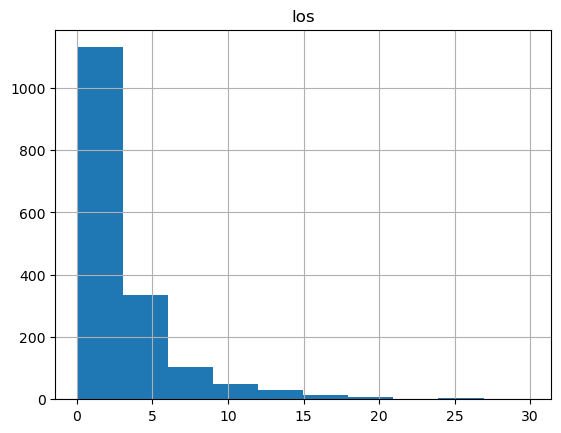

In [15]:
mimic_df.hist(column=["los"], legend=False)

In [16]:
mimic_df['hospital_expire_flag'] = pd.to_numeric(mimic_df['hospital_expire_flag'], downcast='integer')
# !!! FLIPPING MORTALITY FLAG FOR TESTING !!!
# mimic_df['hospital_expire_flag'] = mimic_df['hospital_expire_flag'].replace({0:1, 1:0})

mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot,time_series_path
3056,f698fd94-7f265c9d-7cc265a7-f0202e64-324d627b,11922103,55850277,CHEST (PORTABLE AP),AP,21160809,143247.734,/data/datasets/resized/f698fd94-7f265c9d-7cc26...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,21211040,38256253,2116-08-09 04:44:00,2116-08-12 18:55:50,3.591551,M810,10.0,Age-related osteoporosis without current patho...,9802,9.0,Removal of intraluminal foreign body from esop...,NaN,EW EMER.,EMERGENCY ROOM,OTHER FACILITY,Medicare,ENGLISH,SINGLE,WHITE,2116-08-08 19:13:00,2116-08-09 04:44:00,0,M,32.0,2116.0,2014 - 2016,NaN,38256253.0,admit,Surgical Intensive Care Unit (SICU),"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/38256253.csv
3057,1d441afb-96802caf-1602d6cf-4a538abf-27678c49,11922236,51077514,CHEST (PORTABLE AP),AP,21500524,210103.468,/data/datasets/resized/1d441afb-96802caf-1602d...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,27021287,30139512,2150-05-24 22:42:00,2150-05-26 15:17:17,1.691169,M1A9XX0,10.0,"Chronic gout, unspecified, without tophus (tophi)",NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Other,?,WIDOWED,BLACK/AFRICAN AMERICAN,2150-05-24 21:06:00,2150-05-24 22:42:00,0,M,89.0,2145.0,2011 - 2013,NaN,30139512.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",/home/mason/TFN/patient_time_series/30139512.csv
3058,960c46ab-f0277cba-9825e3bd-6e518c28-dc5ab47f,11922572,56000555,CHEST (PORTABLE AP),AP,21201128,135920.625,/data/datasets/resized/960c46ab-f0277cba-9825e...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29455916,33952984,2120-11-28 16:55:00,2120-11-29 13:29:36,0.857361,E871,10.0,Hypo-osmolality and hyponatremia,9925,9.0,Injection or infusion of cancer chemotherapeut...,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2120-11-28 13:02:00,2120-11-28 16:55:00,0,M,58.0,2120.0,2011 - 2013,NaN,33952984.0,admit,Medical/Surgical Intensive Care Unit (MICU/SICU),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",/home/mason/TFN/patient_time_series/33952984.csv
3060,d72b1a98-aa8a03a9-163e7a79-3274f7d1-fe590cb2,11924068,56444505,CHEST (PORTABLE AP),AP,21730929,195302.906,/data/datasets/resized/d72b1a98-aa8a03a9-163e7...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,WET READ: ___ ___ ___ 11:08 PM\n In comparis...,27844909,38843845,2173-09-29 10:46:00,2173-10-03 21:00:49,4.426956,R791,10.0,Abnormal coagulation profile,966,9.0,Enteral infusion of concentrated nutritional s...,NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,?,SINGLE,BLACK/AFRICAN AMERICAN,2173-09-29 04:46:00,2173-09-29 10:46:00,0,M,91.0,2173.0,2011 - 2013,NaN,38843845.0,admit,Medical/Surgical Intensive Care Unit (MICU/SICU),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/38843845.csv
3061,39056dad-9a36854a-5402b962-56c692eb-fb9f2941,11924161,51437353,CHEST (PORTABLE AP),AP,21890213,141857.750,/data/datasets/resized/39056dad-9a36854a-5402b...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,29477725,38342350,2189-02-13 15:54:59,2189-02-14 15:49:07,0.995926,I2510,10.0,Atherosclerotic heart disease of native corona...,NaN,NaN,NaN,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,SINGLE,WHITE,2189-02-12 23:04:00,2189-02-13 03:30:00,0,F,91.0,2188.0,2011 - 2013,NaN,38342350.0,transfer,Surgical Intensive Care Unit (SICU),"[0, 0, 0, 0, 0, 

In [17]:
# TEMP: Save complete MIMIC dataset

# mimic_df.to_pickle("Final_MIMIC.pkl")

Count num of survivors and mortalities. 
0 == survival & 1 == mortality

In [17]:
mimic_df['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    1479
1     197
Name: count, dtype: int64

Split survivors from mortalities in MIMIC

In [19]:
survivor_df = mimic_df.drop(mimic_df[mimic_df['hospital_expire_flag'] == 1].index)
survivor_df = survivor_df.drop(mimic_df[mimic_df['hospital_expire_flag'] == 0].index)

survivor_df['hospital_expire_flag'].value_counts()

Series([], Name: count, dtype: int64)

In [20]:
mimic_df = mimic_df.drop(mimic_df[mimic_df['hospital_expire_flag'] == 0].index)

mimic_df['hospital_expire_flag'].value_counts()

hospital_expire_flag
1    197
Name: count, dtype: int64

Take a certain percentage of survivors ONLY.

In [21]:
# Take subset of 2% survivors only
survivor_df = survivor_df.sample(frac=0.2, replace=True, random_state=1)

survivor_df['hospital_expire_flag'].value_counts()

Series([], Name: count, dtype: int64)

Concat goether & sort the dataframe by time again.

In [22]:
mimic_df = pd.concat([mimic_df, survivor_df])

In [23]:
mimic_df = mimic_df.sort_values(by=['StudyTime'])

In [24]:
mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot,time_series_path
4114,5cc17570-4aafe3ca-a2b9e894-b5104faf-c0e3c2fc,12540572,51199145,CHEST (PORTABLE AP),AP,21210312,1300.125,/data/datasets/resized/5cc17570-4aafe3ca-a2b9e...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28490788,37506514,2121-03-12 03:47:00,2121-03-15 18:29:43,3.612998,G931,10.0,"Anoxic brain damage, not elsewhere classified",9671,9.0,Continuous invasive mechanical ventilation for...,2121-03-15 16:40:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2121-03-11 23:52:00,2121-03-12 03:47:00,1,M,79.0,2121.0,2011 - 2013,2121-03-15,37506514.0,admit,Coronary Care Unit (CCU),"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...",/home/mason/TFN/patient_time_series/37506514.csv
3425,3e937aee-29423b9e-a263f825-3dca3f6a-4b496034,12118363,51182943,CHEST (PORTABLE AP),AP,21390818,1402.531,/data/datasets/resized/3e937aee-29423b9e-a263f...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,23198189,39250219,2139-08-18 05:09:25,2139-08-22 16:50:15,4.486690,Z87891,10.0,Personal history of nicotine dependence,4A023N6,10.0,"Measurement of Cardiac Sampling and Pressure, ...",2139-08-23 05:25:00,OBSERVATION ADMIT,EMERGENCY ROOM,DIED,Medicare,ENGLISH,MARRIED,WHITE,2139-08-17 23:24:00,2139-08-18 02:59:00,1,M,66.0,2134.0,2008 - 2010,2139-08-23,39250219.0,admit,Coronary Care Unit (CCU),"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, ...",/home/mason/TFN/patient_time_series/39250219.csv
3607,411a70f5-cac14485-cf0baa53-7c7e5e71-cb0edebf,12238407,53130259,CHEST (PORTABLE AP),AP,21670805,2159.250,/data/datasets/resized/411a70f5-cac14485-cf0ba...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26245624,38683657,2167-08-05 02:37:00,2167-08-14 08:54:51,9.262396,K567,10.0,"Ileus, unspecified",9672,9.0,Continuous invasive mechanical ventilation for...,2167-08-14 04:05:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,SINGLE,WHITE,2167-08-04 23:43:00,2167-08-05 02:37:00,1,M,41.0,2167.0,2014 - 2016,2167-08-14,38683657.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/38683657.csv
3420,ed258b72-dc10dcf2-74c3de7e-fc182840-3c8fdcfb,12116846,54593032,CHEST (PORTABLE AP),AP,21281202,3351.312,/data/datasets/resized/ed258b72-dc10dcf2-74c3d...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,25489153,34161336,2128-12-02 00:11:06,2128-12-02 23:32:53,0.973461,F17210,10.0,"Nicotine dependence, cigarettes, uncomplicated",041L0JL,10.0,Bypass Left Femoral Artery to Popliteal Artery...,2128-12-02 19:50:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,DIED,Other,ENGLISH,SINGLE,WHITE,NaN,NaN,1,M,84.0,2128.0,2014 - 2016,2128-12-02,34161336.0,transfer,Cardiac Vascular Intensive Care Unit (CVICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/34161336.csv
4282,096e049a-5ec55522-fa47c30d-32146677-45315a3a,12653962,52859704,CHEST (PA AND LAT),PA,21180418,3527.484,/data/datasets/resized/096e049a-5ec55522-fa47c...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26977901,38093768,2118-04-18 01:52:00,2118-04-20 18:23:48,2.688750,K219,10.0,Gastro-esophageal reflux disease without esoph...,NaN,NaN,NaN,2118-04-30 16:00:00,OBSERVATION ADMIT,EMERGENCY ROOM,DIED,Medicare,ENGLISH,WIDOWED,WHITE,2118-04-17 22:12:00,2118-04-18 01:52:00,1,M,85.0,2118.0,2014 - 2016,2118-04-30,38093768.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1,

Save the modified MIMIC dataset for future reference.

In [25]:
mimic_df.to_pickle("Final_MIMIC_0%-SURV.pkl")

Load previously generated MIMIC dataset (if we want to)

In [6]:
if (True):
    pd.options.display.max_columns = None

    mimic_df = pd.read_pickle("Final_MIMIC_20%-SURV.pkl")

In [26]:
mimic_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,StudyDate,StudyTime,image_path,text_path,note,hadm_id,stay_id,intime,outtime,los,diagnosis_icd_code,diagnosis_icd_version,diagnosis_long_title,procedure_icd_code,procedure_icd_version,procedure_long_title,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,transfer_id,eventtype,careunit,one_hot,time_series_path
4114,5cc17570-4aafe3ca-a2b9e894-b5104faf-c0e3c2fc,12540572,51199145,CHEST (PORTABLE AP),AP,21210312,1300.125,/data/datasets/resized/5cc17570-4aafe3ca-a2b9e...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,28490788,37506514,2121-03-12 03:47:00,2121-03-15 18:29:43,3.612998,G931,10.0,"Anoxic brain damage, not elsewhere classified",9671,9.0,Continuous invasive mechanical ventilation for...,2121-03-15 16:40:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2121-03-11 23:52:00,2121-03-12 03:47:00,1,M,79.0,2121.0,2011 - 2013,2121-03-15,37506514.0,admit,Coronary Care Unit (CCU),"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...",/home/mason/TFN/patient_time_series/37506514.csv
3425,3e937aee-29423b9e-a263f825-3dca3f6a-4b496034,12118363,51182943,CHEST (PORTABLE AP),AP,21390818,1402.531,/data/datasets/resized/3e937aee-29423b9e-a263f...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,23198189,39250219,2139-08-18 05:09:25,2139-08-22 16:50:15,4.486690,Z87891,10.0,Personal history of nicotine dependence,4A023N6,10.0,"Measurement of Cardiac Sampling and Pressure, ...",2139-08-23 05:25:00,OBSERVATION ADMIT,EMERGENCY ROOM,DIED,Medicare,ENGLISH,MARRIED,WHITE,2139-08-17 23:24:00,2139-08-18 02:59:00,1,M,66.0,2134.0,2008 - 2010,2139-08-23,39250219.0,admit,Coronary Care Unit (CCU),"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, ...",/home/mason/TFN/patient_time_series/39250219.csv
3607,411a70f5-cac14485-cf0baa53-7c7e5e71-cb0edebf,12238407,53130259,CHEST (PORTABLE AP),AP,21670805,2159.250,/data/datasets/resized/411a70f5-cac14485-cf0ba...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26245624,38683657,2167-08-05 02:37:00,2167-08-14 08:54:51,9.262396,K567,10.0,"Ileus, unspecified",9672,9.0,Continuous invasive mechanical ventilation for...,2167-08-14 04:05:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,SINGLE,WHITE,2167-08-04 23:43:00,2167-08-05 02:37:00,1,M,41.0,2167.0,2014 - 2016,2167-08-14,38683657.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/38683657.csv
3420,ed258b72-dc10dcf2-74c3de7e-fc182840-3c8fdcfb,12116846,54593032,CHEST (PORTABLE AP),AP,21281202,3351.312,/data/datasets/resized/ed258b72-dc10dcf2-74c3d...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,25489153,34161336,2128-12-02 00:11:06,2128-12-02 23:32:53,0.973461,F17210,10.0,"Nicotine dependence, cigarettes, uncomplicated",041L0JL,10.0,Bypass Left Femoral Artery to Popliteal Artery...,2128-12-02 19:50:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,DIED,Other,ENGLISH,SINGLE,WHITE,NaN,NaN,1,M,84.0,2128.0,2014 - 2016,2128-12-02,34161336.0,transfer,Cardiac Vascular Intensive Care Unit (CVICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...",/home/mason/TFN/patient_time_series/34161336.csv
4282,096e049a-5ec55522-fa47c30d-32146677-45315a3a,12653962,52859704,CHEST (PA AND LAT),PA,21180418,3527.484,/data/datasets/resized/096e049a-5ec55522-fa47c...,/data/datasets/mimic-cxr-jpg/mimic-cxr-jpg-2.0...,FINAL REPORT\...,26977901,38093768,2118-04-18 01:52:00,2118-04-20 18:23:48,2.688750,K219,10.0,Gastro-esophageal reflux disease without esoph...,NaN,NaN,NaN,2118-04-30 16:00:00,OBSERVATION ADMIT,EMERGENCY ROOM,DIED,Medicare,ENGLISH,WIDOWED,WHITE,2118-04-17 22:12:00,2118-04-18 01:52:00,1,M,85.0,2118.0,2014 - 2016,2118-04-30,38093768.0,admit,Medical Intensive Care Unit (MICU),"[0, 0, 0, 0, 0, 0, 0, 0, 1,

In [17]:
# README: stay_id to map time-series to patients
# - tensor decomposition after all 3 models have been concatenated/fused
# - change LSTM --> CNN-LSTM?
# - discrete time survival model
#     - should predict mortality

In [18]:
# Poster Notes:
# Framework to describe what I am trying to do
# Make a nice picture to describe the flow
# Show some results
# Do both Cox & Classification + Regression comparison
#    There is a possibilty the cox model is very bad

### Define Patient Dataset and Dataloader

#### Patient Dataset

In [27]:
# CustomDataset contains the MIMIC-IV Dataframe, with each row corresponding to a patient in the MIMIC-IV dataset.
class Patient_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe # Reference the MIMIC-IV Dataframe.
        self.transform = transform # Apply any given transformations.

    def __getitem__(self, index):
        row = self.dataframe.iloc[index] # Get the row (patient) we want to read.

        image = Image.open(row['image_path'])
        if self.transform :
            image = self.transform(image)
        
        # For Cox Model, label should be in the tuple: duration, event
        los = torch.tensor(row['los'], dtype=torch.float32)
        expire_flag = torch.tensor(row['hospital_expire_flag'], dtype=torch.float32)
        label = (los, expire_flag)
        
        demographics = torch.tensor(row['one_hot'], dtype=torch.float32)
    
        time_series = pd.read_csv(row['time_series_path'])
    
        # Drop charttime, since it isn't a feature
        time_series = time_series.drop('charttime', axis=1)

        # perform imputation
        time_series = time_series.ffill()
        time_series = time_series.bfill()
        
        # Convert to Tensor
        time_series_tensor = torch.tensor(time_series.values, dtype=torch.float32)
        
        patient = (image, demographics, time_series_tensor)
        
        return patient, label

    def __len__(self):
        return len(self.dataframe)

#### Split MIMIC-IV Dataset

In [28]:
# Split MIMIC-IV Dataset into 80-20% for training and testing.
train = mimic_df.sample(frac=0.8,random_state=200)
test = mimic_df.drop(train.index)

print(len(train))
print(len(test))
# train

158
39


#### Define Patient Dataloader

In [29]:
# Data augmentation and normalization for training
# Just normalization for validation
# Will need to be applied by passing in to Dataset constructor!
data_transforms = {
    'train': transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize((0.5), (0.5))
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.5), (0.5))
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dl_args = dict(batch_size=16, num_workers=4)

# Dataloaders used to iterate through the patients. Patients split 80-20% into train-test loaders.
train_dataset = Patient_Dataset(train, data_transforms['train'])
train_dataset.transform = data_transforms['train']
train_dataloader = DataLoader(train_dataset)

test_dataset = Patient_Dataset(test, data_transforms['test'])
test_dataset.transform = data_transforms['test']
test_dataloader = DataLoader(test_dataset)

dataloaders = {'train': train_dataloader,
              'test': test_dataloader,
              }

i = 0
for patient in dataloaders['train']:
    i = i + 1
    if i > 5:
        break
    print(patient)

"""
dl_args = dict(batch_size=16, num_workers=4)

train_dl = DataLoader(train_ds, **dl_args)
valid_dl = DataLoader(val_ds , **dl_args)
"""

[[tensor([[[[ 0.4851,  0.3309,  0.1597,  ...,  0.2967,  0.2967,  0.2624],
          [ 0.3309,  0.2453,  0.1597,  ...,  0.0912,  0.1939,  0.1939],
          [ 0.2111,  0.1597,  0.1426,  ..., -0.0801, -0.0629, -0.0458],
          ...,
          [ 1.2728,  1.2899,  1.2899,  ...,  0.3652,  0.2624,  0.2796],
          [ 1.2899,  1.3070,  1.3070,  ...,  0.3823,  0.3481,  0.3652],
          [ 1.3070,  1.3070,  1.3242,  ...,  0.3309,  0.3823,  0.3994]],

         [[ 0.6254,  0.4678,  0.2927,  ...,  0.4328,  0.4328,  0.3978],
          [ 0.4678,  0.3803,  0.2927,  ...,  0.2227,  0.3277,  0.3277],
          [ 0.3452,  0.2927,  0.2752,  ...,  0.0476,  0.0651,  0.0826],
          ...,
          [ 1.4307,  1.4482,  1.4482,  ...,  0.5028,  0.3978,  0.4153],
          [ 1.4482,  1.4657,  1.4657,  ...,  0.5203,  0.4853,  0.5028],
          [ 1.4657,  1.4657,  1.4832,  ...,  0.4678,  0.5203,  0.5378]],

         [[ 0.8448,  0.6879,  0.5136,  ...,  0.6531,  0.6531,  0.6182],
          [ 0.6879,  0.6008,

'\ndl_args = dict(batch_size=16, num_workers=4)\n\ntrain_dl = DataLoader(train_ds, **dl_args)\nvalid_dl = DataLoader(val_ds , **dl_args)\n'

### Time Series Dataset & Dataloader
!!! Used for training autoencoder only !!!

#### Custom Collate Function

In [30]:
# collate_fn handles padding on inputs.
def collate_fn(batch):
    # Separate the data and labels
    sequences, labels = zip(*batch)
    
    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    
    # Stack labels into a tensor
    labels = torch.stack(labels)
    
    return padded_sequences, labels

#### Time Series Dataset

In [31]:
# Initialize encoders
onehot_encoder = OneHotEncoder(sparse_output=False)
label_encoder = LabelEncoder()

class InHospitalMortalityDataset(Dataset):
    def __init__(self, dataset_dir, listfile, imputation_method='forward_fill', categorical_columns=None):
        self.dataset_dir = dataset_dir
        self.data_info = pd.read_csv(listfile)
        self.imputation_method = imputation_method
        self.categorical_columns = categorical_columns
        
        self.preprocess()
        
    def __len__(self):
        return len(self.data_info)
    
    def impute_missing_values(self, data):
        if self.imputation_method == 'forward_fill':
            data = data.ffill()
            data = data.bfill()
            return data
        elif self.imputation_method == 'backward_fill':
            data = bfill()
            data = ffill()
            return data
        elif self.imputation_method == 'interpolate':
            return data.interpolate(method='linear', limit_direction='both')
        else:
            raise ValueError(f"Unknown imputation method: {self.imputation_method}")
            
    def impute_na(self, data):
        return data.fillna(0)
    
    def encode_categorical(self, data):
        if self.categorical_columns is not None:
            for col in self.categorical_columns:
                if data[col].dtype == 'object':  # Assuming categorical columns are of type 'object'
                    if col in data.columns:
                        data[col] = label_encoder.fit_transform(data[col].astype(str))
        return data
    
    def remove_vars(self, panda):
        panda = panda.drop('charttime', axis=1)
        
        return panda
    
    # get_panda returns a panda represeting a time-series study for a patient, 
    # given a Panda row from a list panda indicating file location.
    def get_panda(self, row):
        file_name = row['time_series_path']

        time_series_data = pd.read_csv(file_name)
        
        return time_series_data
    
    # https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
    def isnull(self, df):
        return df.isnull().values.any()
    
    # preprocess checks the dataset for bad entries (NaN present after imputation) and drops them.
    def preprocess(self):
        drop_indexes = []
        
        for idx in self.data_info.index:
            row = self.data_info.iloc[idx]
            study = self.get_panda(row)
        
            # Remove Hour as time passed column
            study = self.remove_vars(study)
        
            # Impute missing values
            study = self.impute_missing_values(study)

            # Get just number of data points in each study.
            study_length = study.shape[0]
            
            # Check for excessive length (longer length than 30,000 data points)
            if study_length > 30000:
                # Store the index for deletion
                drop_indexes.append(idx)
                
            # Check for NaN after imputation
            if self.isnull(study):
                # Store the index for deletion
                drop_indexes.append(idx)
                
            if len(study.columns) != AUTOENCODER_INPUTS:
                drop_indexes.append(idx)
                
        # Delete all rows that have studies that are too long, or contain NaN after imputation.
        self.data_info.drop(drop_indexes, axis=0, inplace=True)
    
    def __getitem__(self, idx):
        row = self.data_info.iloc[idx]
        time_series_data = self.get_panda(row)
        
        # Remove Hour as time passed column
        time_series_data = self.remove_vars(time_series_data)
        
        # Impute missing values
        time_series_data = self.impute_missing_values(time_series_data)
        
        # Encode categorical variables
#         time_series_data = self.encode_categorical(time_series_data)
        
        # Convert to torch tensor
        time_series_tensor = torch.tensor(time_series_data.values, dtype=torch.float32)
        
        return time_series_tensor, time_series_tensor  # Input and target are the same

#### Time Series Dataloader

In [32]:
train_listfile_path = 'time_series_list.csv'
train_files_path = '/home/mason/TFN/patient_time_series'
batch_size = 1

time_train_dataset = InHospitalMortalityDataset(
    dataset_dir=train_files_path,
    listfile=train_listfile_path,
    imputation_method='forward_fill',
    categorical_columns=[])

time_train_loader = DataLoader(dataset=time_train_dataset, batch_size=batch_size, shuffle=True, \
                               collate_fn=collate_fn)

i = 0
for time_series, label in time_train_loader:
    i = i + 1
    if i > 5:
        break
    print(time_series)

tensor([[[0.0000e+00, 9.3000e+01, 9.7000e+01, 9.5000e+01, 1.7000e+01,
          9.7800e+01],
         [1.0000e-01, 9.7000e+01, 9.7000e+01, 9.5000e+01, 1.7000e+01,
          9.7800e+01],
         [7.8333e-01, 9.9000e+01, 9.8000e+01, 9.6000e+01, 2.3000e+01,
          9.7800e+01],
         [1.7833e+00, 1.0300e+02, 1.0700e+02, 9.6000e+01, 2.4000e+01,
          9.7800e+01],
         [2.7833e+00, 9.6000e+01, 9.2000e+01, 9.9000e+01, 1.8000e+01,
          9.7800e+01],
         [3.7833e+00, 9.5000e+01, 9.2000e+01, 9.4000e+01, 1.8000e+01,
          9.9600e+01],
         [3.8000e+00, 9.5000e+01, 9.5000e+01, 9.4000e+01, 1.8000e+01,
          9.9600e+01],
         [3.9333e+00, 9.5000e+01, 9.5000e+01, 9.4000e+01, 1.4000e+01,
          9.9600e+01],
         [4.7833e+00, 8.4000e+01, 7.9000e+01, 9.9000e+01, 1.7000e+01,
          9.9600e+01],
         [5.7833e+00, 9.1000e+01, 7.6000e+01, 9.4000e+01, 2.1000e+01,
          9.9600e+01],
         [6.7833e+00, 8.5000e+01, 6.2000e+01, 9.7000e+01, 1.8000e+01,


#### Check for distribution of time-series lengths

<Axes: ylabel='Frequency'>

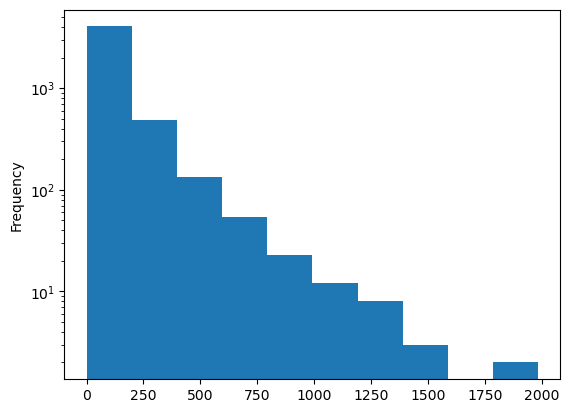

In [33]:
# README: This graph does not show data truncated by the 'preprocess' function in the dataloader.

time_series_lengths = list()

for time_series in time_train_loader:
    length = list(time_series[0].size())
    length = length[1]
    time_series_lengths.append(length)
    
ts_lengths = pd.Series(time_series_lengths) 

ts_lengths.plot(kind='hist', logy=True, legend=False)

## Define Models

The Fusion Network will fuse the embeddings of three input models---X-Ray, Demographics, and Time Series Data.

### X-Ray Embedder

(VGG16)

In [34]:
class ModifiedVGG16Model(torch.nn.Module):
    def __init__(self, model=None):
        super(ModifiedVGG16Model, self).__init__()

        model = models.vgg16(weights='IMAGENET1K_V1')
        self.features = model.features
        
        # When embedding, we only want the output of the first FC layer.
        self.embedder = nn.Sequential(
            nn.Dropout(),
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True)) # This last ReLU layer may be unnecessary
        
        # Contains the Tail of VGG16 (all 3 FC layers and ReLU, when combined with embedder)
        self.classifier = nn.Sequential(
            nn.Linear(4096, 2),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedder(x)
        x = self.classifier(x)
        return x
    
    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedder(x)
        # May need nn.flatten()
        return x

### Demographics Embedder

Ingests:
 - Age
 - Gender
 - Martial Status
 - Ethnicity

All words will need to be reshaped to a common length (set by the longest word/string) and will be concatonated from there so the final dimension of the input tensor (representing concat words) is understood.

In [35]:
class DemographicsEmbedder(torch.nn.Module):
    def __init__(self, model=None):
        super(DemographicsEmbedder, self).__init__()
        
#         wordvec_model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')
#         wordvec_weights = torch.FloatTensor(wordvecmodel.vectors) # formerly syn0, which is soon deprecated
        
        self.features = nn.Sequential(
            nn.Conv1d(1, 10, 3), # Fix input size!
            nn.MaxPool1d(2))
        
        self.embedder = nn.Sequential(
            nn.Dropout(),
            nn.Flatten(),
            nn.Linear(90, 10),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True))

        # FIXME: Update classifier to handle embedding and Conv1D output.
        self.regressor = nn.Sequential(
            nn.Linear(10, 1))
        
        # Use one-hot encoding before embedding.
        # After can use embedder for NN.
#         self.embedder = nn.Sequential(
#             nn.Embedding.from_pretrained(wordvec_weights))
        
    def embed(self, demographics):
        x = demographics
        x = x.view(1, 1, 21) # Reshape tensor to [N, C, L] format expected by Conv1D
        x = self.features(x)
        x = self.embedder(x)
        return x;
        
    def forward(self, demographics):
        x = demographics
        x = x.view(1, 1, 21) # Reshape tensor to [N, C, L] format expected by Conv1D
        x = self.features(x)
        x = self.embedder(x)
        x = self.regressor(x)
        return x;

In [36]:
# Test Demographics Embedder
def test_demographics():
    test_demo_embedder = DemographicsEmbedder()

    i = 0
    for entry in dataloaders['train']:
        patient = entry[0]
        label = entry[1]
        
        demographics = patient[1]
        
        i = i + 1
        if i > 5:
            break
    #     print(patient)
    #     print(patient[2])
    #     print(patient[2][1][0])
    #     print(type(patient[2][1][0]))
        print(test_demo_embedder.forward(demographics))
        
test_demographics()

tensor([[-0.2302]], grad_fn=<AddmmBackward0>)
tensor([[-0.2355]], grad_fn=<AddmmBackward0>)
tensor([[-0.3127]], grad_fn=<AddmmBackward0>)
tensor([[-0.0982]], grad_fn=<AddmmBackward0>)
tensor([[-0.1792]], grad_fn=<AddmmBackward0>)


### Time Series Data Autoencoder

#### Define Autoencoder

In [37]:
class Time_Series_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Time_Series_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_size, latent_size)
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.decoder = nn.LSTM(hidden_size, input_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)  # Additional final linear layer

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Encoder
        packed_h, (h, c) = self.encoder(packed_x)
        h = h[-1]  # Get the hidden state from the last layer of the LSTM
        latent = self.hidden_to_latent(h)
        
        # Prepare for decoder
        hidden = self.latent_to_hidden(latent).unsqueeze(0)
        cell = torch.zeros_like(hidden)
        
        # Decoder
        packed_output, _ = self.decoder(packed_x, (hidden, cell))
        
        # Pad the packed sequence
        decoded, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply the final linear layer to map hidden state to input size
        decoded = self.output_layer(decoded)
        
        return latent, decoded
    
    def encode(self, x, lengths):
        with torch.no_grad():
            # Pack the padded sequence
            packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            
            # Encoder
            packed_h, (h, c) = self.encoder(packed_x)
            h = h[-1]  # Get the hidden state from the last layer of the LSTM
            latent = self.hidden_to_latent(h)
        
        return latent

#### Autoencoder without Training

In [38]:
# Define Autoencoder Parameters
input_size = AUTOENCODER_INPUTS  # Number of features in time series data
hidden_size = 32
latent_size = 16 # Attempt to get good bottleneck, given large length of time-series data.

test_autoencoder = Time_Series_Autoencoder(input_size, hidden_size, latent_size)

# test_autoencoder.to(device)

# Forward pass example
for time_series, label in time_train_loader:
    lengths = [len(seq) for seq in time_series]
    latent, reconstructed = test_autoencoder(time_series, lengths)
    print("Original Shape", time_series.shape)
    print("Latent representation shape:", latent.shape)
    print("Reconstructed shape:", reconstructed.shape)
#     print(time_series)
#     print(latent)
#     print(reconstructed)
    break

Original Shape torch.Size([1, 54, 6])
Latent representation shape: torch.Size([1, 16])
Reconstructed shape: torch.Size([1, 54, 6])


#### Training Autoencoder

In [39]:
def train_autoencoder(model, dataloader, num_epochs, learning_rate):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    print("Beginning Training")
    print("Total Entries:", len(dataloader))
    
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        currIdx = 0
        for time_series, label in dataloader:
            # Calculate lengths of sequences (non-zero length for padded sequences)
#             print(time_series)
            lengths = [len(seq) for seq in time_series]
#             print("Lengths Calculated")
            
            optimizer.zero_grad()
            latent, reconstructed = model(time_series, lengths)

            loss = criterion(reconstructed, time_series)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
#             print("Original Sequence:")
#             print(sequences)
#             print("Autoencoder Reconstruction:")
#             print(reconstructed)
#             print("Loss:")
#             print(loss)
        
            currIdx = currIdx + 1
            if (currIdx % 100 == 0):
                print("Current Entry:", currIdx)
                print("Current Loss:", loss.item())
        
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        
    model.eval()

In [40]:
num_epochs = 6
learning_rate = 0.001

# train_autoencoder(test_autoencoder, time_train_loader, num_epochs, learning_rate)

# torch.save(test_autoencoder, "6var_ts_20%surv")

#### Autoencoder after training

In [41]:
completed_autoencoder = torch.load('6var_ts_20%surv')#.to(device)

# completed_autoencoder.to(device)

for time_series, label in time_train_loader:
    lengths = [len(seq) for seq in time_series]
    latent, reconstructed = completed_autoencoder(time_series, lengths)
    print("Original Shape", time_series.shape)
    print("Latent representation shape:", latent.shape)
    print("Reconstructed shape:", reconstructed.shape)
#     print(time_series)
#     print(latent)
#     print(reconstructed)
    break

Original Shape torch.Size([1, 83, 6])
Latent representation shape: torch.Size([1, 16])
Reconstructed shape: torch.Size([1, 83, 6])


### Complete Model - Concat

(Contains X-Ray Embedder and Demographics Embedder) \
forward output a joint concatenation of all extracted features.

In [42]:
class MedicalConcatNetwork(torch.nn.Module):
    def __init__(self, model=None):
        super(MedicalConcatNetwork, self).__init__()
        
        self.visual_embedder = ModifiedVGG16Model()
        self.demographics_embedder = DemographicsEmbedder()
        self.autoencoder = torch.load('6var_ts_20%surv')
        
        self.shared_features = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4122, 4122),
            nn.ReLU(inplace=True))
        
        self.regression = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4122, 2053),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2053, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1))
        
        self.classification = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4122, 2053),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2053, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid())
        
    def feature_output(self, imagery, demographics, time_series):
        visual_features = self.visual_embedder.embed(imagery)
        demographic_features = self.demographics_embedder.embed(demographics)
        
        lengths = [len(seq) for seq in time_series]
        latent, reconstructed = self.autoencoder(time_series, lengths)
#         print(visual_features.shape, demographic_features.shape, latent.shape)
        concat_features = torch.concat((visual_features, demographic_features, latent), 1) 
        
        return concat_features
        
    def regression_classification(self, patient):
        imagery = patient[0]
        demographics = patient[1]
        time_series = patient[2]
        
        fusion = self.feature_output(imagery, demographics, time_series)
        
        shared = self.shared_features(fusion)
        los = self.regression(shared)
        mortality = self.classification(shared)
        out = (los, mortality)
        return out
    
    def forward(self, patient):
        imagery = patient[0]
        demographics = patient[1]
        time_series = patient[2]
        
        fusion = self.feature_output(imagery, demographics, time_series)
        
        shared = self.shared_features(fusion)
        return shared

### Complete Model - Fusion

(Contains X-Ray Embedder and Demographics Embedder)

In [43]:
class MedicalFusionNetwork(torch.nn.Module):
    def __init__(self, model=None):
        super(MedicalFusionNetwork, self).__init__()
        
        self.visual_embedder = ModifiedVGG16Model()
        self.demographics_embedder = DemographicsEmbedder()
        self.autoencoder = torch.load('6var_ts_autoencoder')
        
        self.compressor = nn.Linear(4096, 2048)
        
        self.kron_compressor = nn.Linear(22539, 5634)
        
        self.shared_features = nn.Sequential(
            nn.Dropout(),
            nn.Linear(95778, 23944),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(23944, 5986),
            nn.ReLU(inplace=True))
        
        self.regression = nn.Sequential(
            nn.Dropout(),
            nn.Linear(5986, 249),
            nn.ReLU(inplace=True),
            nn.Linear(249, 1))
        
        self.classification = nn.Sequential(
            nn.Dropout(),
            nn.Linear(5986, 249),
            nn.ReLU(inplace=True),
            nn.Linear(249, 1),
            nn.Sigmoid())
        
    def feature_output(self, imagery, demographics, time_series):
        # Perform feature extraction for all three modalities.
        visual_features = self.visual_embedder.embed(imagery)
        visual_features = self.compressor(visual_features)
        demographic_features = self.demographics_embedder.embed(demographics)
        lengths = [len(seq) for seq in time_series]
        latent, reconstructed = self.autoencoder(time_series, lengths)
        
        # Do tensor fusion to obtain joint representation of all features.
        visual_h = torch.concat((torch.ones(1, 1).to(device), visual_features), dim=1)
        demographics_h = torch.concat((torch.ones(1, 1).to(device), demographic_features), dim=1)
        time_series_h = torch.concat((torch.ones(1, 1).to(device), latent), dim=1)
        
#         print(visual_h.size())
#         print(demographics_h.size())
#         print(time_series_h.size())
        
#         fusion = torch.kron(visual_h, torch.kron(demographics_h, time_series_h))
        fusion = torch.kron(visual_h, demographics_h)
        fusion = self.kron_compressor(fusion)
        fusion = torch.kron(time_series_h, fusion)
#         print(fusion.size())
#         print(fusion)
        
        # FIXME: Implement dropout later.
        shared = self.shared_features(fusion)
        
        return shared
        
    def regression_classification(self, patient):
        imagery = patient[0]
        demographics = patient[1]
        time_series = patient[2]
        
        fusion = self.feature_output(imagery, demographics, time_series)
        
        los = self.regression(fusion)
        mortality = self.classification(fusion)
        out = (los, mortality)
        return out
    
    def forward(self, patient):
        imagery = patient[0]
        demographics = patient[1]
        time_series = patient[2]
        
        fusion = self.feature_output(imagery, demographics, time_series)
        
        return fusion

## Testing Complete Model

Untrained Concatenation.

In [48]:
concat_medical_network = MedicalConcatNetwork()

def test_medical_concat():
    i = 0
    for entry in dataloaders['train']:
        i = i + 1
        if i > 5:
            break
        patient = entry[0]
        label = entry[1]
        pred = concat_medical_network.regression_classification(patient)
        print("Label:")
        print(label)
        print("Prediction:")
        print(pred)
        
test_medical_concat()

Label:
[tensor([0.9867]), tensor([1.])]
Prediction:
(tensor([[0.0912]], grad_fn=<AddmmBackward0>), tensor([[0.5188]], grad_fn=<SigmoidBackward0>))
Label:
[tensor([0.6892]), tensor([1.])]
Prediction:
(tensor([[0.0606]], grad_fn=<AddmmBackward0>), tensor([[0.5119]], grad_fn=<SigmoidBackward0>))
Label:
[tensor([0.9466]), tensor([1.])]
Prediction:
(tensor([[0.0789]], grad_fn=<AddmmBackward0>), tensor([[0.5143]], grad_fn=<SigmoidBackward0>))
Label:
[tensor([1.6744]), tensor([1.])]
Prediction:
(tensor([[0.0810]], grad_fn=<AddmmBackward0>), tensor([[0.5131]], grad_fn=<SigmoidBackward0>))
Label:
[tensor([1.9112]), tensor([1.])]
Prediction:
(tensor([[0.0727]], grad_fn=<AddmmBackward0>), tensor([[0.5107]], grad_fn=<SigmoidBackward0>))


Untrained Fusion

In [37]:
fusion_medical_network = MedicalFusionNetwork()
fusion_medical_network.to(device)

def test_fusion_concat():
    i = 0
    for entry in dataloaders['train']:
        i = i + 1
        if i > 5:
            break
        patient = entry[0]
        patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
        label = entry[1]
        label = (label[0].to(device), label[1].to(device))
        pred = fusion_medical_network.regression_classification(patient)
        print("Label:")
        print(label)
        print("Prediction:")
        print(pred)
        
test_fusion_concat()

## Train Model

### Define Trainer

In [45]:
class Trainer:
    def __init__(self, dataloaders, model, optimizer):
        self.optimizer = optimizer

        self.model = model
        self.model.to(device)
        self.classification_criterion = torch.nn.BCELoss()
        self.regression_criterion = torch.nn.MSELoss()
        self.model.train()

    def test(self):
        self.model.eval()
        total = 0
        total_time = 0
        preds = []
        regression_labels = []
        classification_labels = []
        regression_outputs = []
        classification_outputs = []
        
        for i, (entry) in enumerate(dataloaders['test']):
            # Get image, demographics, and label from dataloader and send to device.
            patient = entry[0]
            patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
            label = entry[1]
            label = (label[0].to(device), label[1].to(device))
            current_regression_label = label[0].to(device)
            current_classification_label = label[1].to(device)

            # Add each label to list keeping track of all entries.
            regression_labels.extend(current_regression_label.to("cpu"))
            classification_labels.extend(current_classification_label.to("cpu"))

            # Start keeping time, and run model for output.
            t0 = time.time()
            
            output = self.model.regression_classification(patient)
            
            t1 = time.time()
            total_time = total_time + (t1 - t0)
            
            # Add model outputs to output lists. (For later comparison)
            for output_tensor in output[0]:
#                 print("Regression:", output_tensor)
                regression_outputs.extend(output_tensor.to("cpu").detach().numpy().tolist())
                
            for output_tensor in output[1]:
#                 print("Classification:", output_tensor)
                classification_outputs.extend(output_tensor.to("cpu").detach().numpy().tolist())
        
        # Print model training time and statistics.
        print("=== Regression Accuracy ===")
        print("Mean Squared Error:", mean_squared_error(regression_labels, regression_outputs))
        print("=== Classification Accuracy ===")
        classification_outputs_rounded = [ round(elem) for elem in classification_outputs ]
        classification_labels = [int(x.item()) for x in classification_labels]
#         print(classification_outputs_rounded)
        print("Accuracy Score:", accuracy_score(classification_labels, classification_outputs_rounded))
        calc_time = float(total_time) / (i + 1)
        print("Total Prediction Time:", total_time)
        print('Average Prediction Time: {min}m {sec}s'.format(min=calc_time // 60.0, sec=calc_time % 60.0))
        print("Total Entries Compared: ", i + 1)
#         print(outputs)
        
        return (total_time, regression_labels, regression_outputs, \
                classification_labels, classification_outputs_rounded)

    def train(self, epoches=10):
        self.model.train()
        since = time.time()
        
        for i in range(epoches):
            print("Epoch: ", i)
            self.train_epoch()
            self.test()
            self.model.train()
            
        print("Finished fine tuning.")
        time_elapsed = time.time() - since
        print(f'Training complete in  {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        

    def train_batch(self, patient, regression_label, classification_label):
        self.model.train()
        # Not sure why double works fine for forward, but not for backwards. .float() is here to fix this.
        
        output = self.model.regression_classification(patient)
        model_regression = output[0].float()
        model_classification = output[1].float()
        
        regression_loss = self.regression_criterion(model_regression, regression_label.float())
        
        classification_loss = self.classification_criterion(model_classification, classification_label.float())
        
#         main_weight = 0.2
#         aux_weight = 0.8
        main_weight = 0.5
        aux_weight = 0.5
        
        total_loss = (main_weight * regression_loss) + (aux_weight * classification_loss)
        
        self.model.zero_grad()
        total_loss.backward()
        self.optimizer.step()

    def train_epoch(self):
        for i, (entry) in enumerate(dataloaders['train']):
            # NOTE: Disable model.to(device) for better traceback.
            self.model.to(device)
            patient = entry[0]
            patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
            label = entry[1]
            label = (label[0].to(device), label[1].to(device))
            regression_label = label[0].to(device)
            classification_label = label[1].to(device)
            # Convert input from [1] to [1, 1] size to match input.
            regression_label = regression_label.unsqueeze(1)
            classification_label = classification_label.unsqueeze(1)
            self.train_batch(patient, regression_label, classification_label)
            if(i % 1000 == 0):
                print(i)

In [46]:
sys.exit(130)

SystemExit: 130

/home/mason/.conda/envs/LOSresearch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Train Model

In [49]:
optimizer = optim.SGD(concat_medical_network.parameters(), lr=0.00007, momentum=0.70)
concat_trainer = Trainer(datasets, concat_medical_network, optimizer)

_, _, _, _, _ = concat_trainer.test()

concat_trainer.train(80)

torch.save(concat_medical_network, "6ac_0%Surv")

=== Regression Accuracy ===
Mean Squared Error: 49.612122226215526
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.2666912078857422
Average Prediction Time: 0.0m 0.0068382360996344154s
Total Entries Compared:  39
Epoch:  0
0
=== Regression Accuracy ===
Mean Squared Error: 36.185321028693075
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.263885498046875
Average Prediction Time: 0.0m 0.006766294821714744s
Total Entries Compared:  39
Epoch:  1
0
=== Regression Accuracy ===
Mean Squared Error: 35.535716584393015
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26525425910949707
Average Prediction Time: 0.0m 0.006801391259217873s
Total Entries Compared:  39
Epoch:  2
0
=== Regression Accuracy ===
Mean Squared Error: 34.06672684373895
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26547670364379883
Average Prediction Time: 0.0m 0.006807094965225611s
Total Entries Compared:  39

=== Regression Accuracy ===
Mean Squared Error: 23.953043975698225
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26634931564331055
Average Prediction Time: 0.0m 0.006829469631879757s
Total Entries Compared:  39
Epoch:  33
0
=== Regression Accuracy ===
Mean Squared Error: 26.97255313407955
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.283130407333374
Average Prediction Time: 0.0m 0.007259754034189077s
Total Entries Compared:  39
Epoch:  34
0
=== Regression Accuracy ===
Mean Squared Error: 29.44283778570163
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.2657933235168457
Average Prediction Time: 0.0m 0.006815213423508864s
Total Entries Compared:  39
Epoch:  35
0
=== Regression Accuracy ===
Mean Squared Error: 26.22663972818779
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26604485511779785
Average Prediction Time: 0.0m 0.006821662951738407s
Total Entries Compared:  39

=== Regression Accuracy ===
Mean Squared Error: 22.525430111370387
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26575469970703125
Average Prediction Time: 0.0m 0.006814223069411058s
Total Entries Compared:  39
Epoch:  66
0
=== Regression Accuracy ===
Mean Squared Error: 18.99892303650335
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26615214347839355
Average Prediction Time: 0.0m 0.006824413935343425s
Total Entries Compared:  39
Epoch:  67
0
=== Regression Accuracy ===
Mean Squared Error: 31.55636746370741
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.2657890319824219
Average Prediction Time: 0.0m 0.006815103384164663s
Total Entries Compared:  39
Epoch:  68
0
=== Regression Accuracy ===
Mean Squared Error: 18.737619044556507
=== Classification Accuracy ===
Accuracy Score: 1.0
Total Prediction Time: 0.26562023162841797
Average Prediction Time: 0.0m 0.006810775169959435s
Total Entries Compared: 

Best concat metrics encountered to date: \
\
=== Regression Accuracy === \
Mean Squared Error: 4.561578974028629 \
=== Classification Accuracy === \
Accuracy Score: 0.8686567164179104

In [ ]:
# print(concat_medical_network)

### Train Fusion Model

In [ ]:
optimizer = optim.SGD(concat_medical_network.parameters(), lr=0.01, momentum=0.70)
fusion_trainer = Trainer(datasets, fusion_medical_network, optimizer)

_, _, _, _, _ = fusion_trainer.test()

fusion_trainer.train(10)

torch.save(fusion_medical_network, "6aec_fusion_mfn_R2")

#### Model after Training:

In [ ]:
trained_concat = torch.load('6aec_concat_mfn_R2')

trained_concat_trainer = Trainer(datasets, trained_concat, optimizer)

_, _, _, _, _ = trained_concat_trainer.test()

In [ ]:
trained_fusion = torch.load("6aec_fusion_mfn")

i = 0
for entry in dataloaders['test']:
    i = i + 1
    if i > 5:
        break
    patient = entry[0]
    patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
    label = entry[1]
    label = (label[0].to(device), label[1].to(device))
    pred = trained_fusion.regression_classification(patient)
    print("Label:")
    print(label)
    print("Prediction:")
    print(pred)

# Perform Decomposition on completed TFN Model.

In [ ]:
# Determine whether to use CPD/PARAFAC. Uses Tucker if False.
cp = False
decompose = False
origin_model = '6aec_concat_mfn_R2'
save_name = '6aec_concat_mfn_R2_decomposed'

if decompose:
    model = torch.load(origin_model).to(device)
    model.eval()
    model.to("cpu") # FIXME: Original code moves model to GPU, the CPU. Unnecessary?
    N = len(model.visual_embedder.features._modules.keys())
    for i, key in enumerate(model.visual_embedder.features._modules.keys()):

        if i >= N - 2:
            break
        if isinstance(model.visual_embedder.features._modules[key], torch.nn.modules.conv.Conv2d):
            conv_layer = model.visual_embedder.features._modules[key]
            if cp:
                rank = max(conv_layer.weight.data.numpy().shape)//3
                decomposed = cp_decomposition_conv_layer(conv_layer, rank)
            else:
                print("Tucker Performed!")
                decomposed = tucker_decomposition_conv_layer(conv_layer)

            model.visual_embedder.features._modules[key] = decomposed
            
    M = len(model.demographics_embedder.features._modules.keys())
    for i, key in enumerate(model.demographics_embedder.features._modules.keys()):

        if i >= M - 2:
            break
        if isinstance(model.demographics_embedder.features._modules[key], torch.nn.modules.conv.Conv2d):
            conv_layer = model.demographics_embedder.features._modules[key]
            if cp:
                rank = max(conv_layer.weight.data.numpy().shape)//3
                decomposed = cp_decomposition_conv_layer(conv_layer, rank)
            else:
                print("Tucker Performed!")
                decomposed = tucker_decomposition_conv_layer(conv_layer)

            model.demographics_embedder.features._modules[key] = decomposed

    torch.save(model, save_name)
    print("Decomposed Model Saved!")
else:
    print("Skipping Decomposition, Loading Decomposed Model from File.")

## Test Decomposed Model

In [ ]:
def TestDecomposedModel():
    concat_decomposed_model = torch.load('6aec_concat_mfn_R2_decomposed').to(device)
    concat_decomposed_optimizer = optim.SGD(concat_medical_network.parameters(), lr=0.00007, momentum=0.70)
    concat_decomposed_trainer = Trainer(datasets, concat_medical_network, optimizer)

    _, _, _, d_classification_labels, d_classification_out = concat_decomposed_trainer.test()
    
#     print(d_classification_labels)
#     print(d_classification_out)

#     i = 0
#     for patient in dataloaders['train']:
#         i = i + 1
#         if i > 5:
#             break
#         print(patient)

    example_input, classes = next(iter(dataloaders['train'])) 
    example_input = (example_input[0].to(device), example_input[1].to(device), example_input[2].to(device))
    
    print("")
    print("----- Model Computational Complexity -----")
    # Calculate FLOPs
    flops = torchprofile.profile_macs(concat_decomposed_model, example_input)
    print(f'FLOPs: {flops}')

#     decomposed_macs = calculate_flop(concat_decomposed_model)
    
TestDecomposedModel()

# Preprocessing Features for Cox Survivability Analysis

#### New Patient Dataset & Dataloder containing all Patients
Subject_ID is now also returned in the label for constructing feature dataframe.

In [ ]:
class ID_Patient_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe # Reference the MIMIC-IV Dataframe.
        self.transform = transform # Apply any given transformations.

    def __getitem__(self, index):
        row = self.dataframe.iloc[index] # Get the row (patient) we want to read.

        image = Image.open(row['image_path'])
        if self.transform :
            image = self.transform(image)
        
        los = torch.tensor(row['los'], dtype=torch.float32)
        expire_flag = torch.tensor(row['hospital_expire_flag'], dtype=torch.float32)
        subject_id = torch.tensor(row['subject_id'], dtype=torch.float32)
        stay_id = torch.tensor(row['stay_id'], dtype=torch.float32)
        label = (los, expire_flag, subject_id, stay_id)
        
        demographics = torch.tensor(row['one_hot'], dtype=torch.float32)
    
        time_series = pd.read_csv(row['time_series_path'])
    
        # Drop charttime, since it isn't a feature
        time_series = time_series.drop('charttime', axis=1)

        # perform imputation
        time_series = time_series.ffill()
        time_series = time_series.bfill()
        
        # Convert to Tensor
        time_series_tensor = torch.tensor(time_series.values, dtype=torch.float32)
        
        patient = (image, demographics, time_series_tensor)
        
        return patient, label

    def __len__(self):
        return len(self.dataframe)

In [ ]:
batch_size = 1

Total_ID_Dataset = ID_Patient_Dataset(mimic_df, data_transforms['test'])
Total_ID_Dataset.transform = data_transforms['test']
Total_ID_Dataloader = DataLoader(Total_ID_Dataset, batch_size, shuffle=False)

# i = 0
# for patient in Total_ID_Dataloader:
#     i = i + 1
#     if i > 5:
#         break
#     print(patient)

#### Apply TFN Network for Feature Extraction

In [ ]:
def extract_patient_features():
    processing_tfn_model = torch.load('6aec_concat_mfn_R2').to(device)

    feature_list = []

    for i, (entry) in enumerate(Total_ID_Dataloader):
        patient = entry[0]
        patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
        label = entry[1]
        label = [label[0].item(), label[1].item(), label[2].item(), label[3].item()]
        label[1] = int(label[1])
        label[2] = int(label[2])
        label[3] = int(label[3])

        # get features, put in panda
        output = processing_tfn_model.forward(patient)

        features = output[0]
        features = features.tolist()
        features = features + label

        feature_list.append(features)

    feature_dataframe = pd.DataFrame(feature_list)
    feature_dataframe.rename(columns={4122: 'duration', 4123: 'event', 4124: 'subject_id',\
                                      4125: 'stay_id'}, inplace=True)

    feature_dataframe.drop_duplicates(subset='stay_id', keep='first', inplace=True)
    feature_dataframe.to_csv('fusionmfn_patient_features.csv', index=False)

    feature_dataframe
    
extract_patient_features()

# Survivability Analysis utilizing Cox Survivability Model

#### Load Data into Memory

In [ ]:
cox_train = pd.read_csv('patient_features.csv')
cox_train.drop(['subject_id', 'stay_id'], axis=1, inplace=True)
cox_train.columns = cox_train.columns.astype(str)
# 0 represents survival/censured data, and 1 represents mortality, so flipping is not necessary.
cox_train['event'] = cox_train['event'].replace({0:1, 1:0})
cox_train

In [ ]:
cox_train['event'].sum()

In [ ]:
cox_test = cox_train.sample(frac=0.2)
cox_train = cox_train.drop(cox_test.index)
cox_val = cox_train.sample(frac=0.2)
cox_train = cox_train.drop(cox_val.index)

In [ ]:
cols_standardize = []
cols_leave = list(cox_test.columns)
del cols_leave[-2:]
# cols_leave = list(map(int, cols_leave)) DON'T convert to ints... we don't want this!

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(cox_train).astype('float32')
x_val = x_mapper.transform(cox_val).astype('float32')
x_test = x_mapper.transform(cox_test).astype('float32')

In [ ]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(cox_train)
y_val = get_target(cox_val)
durations_test, events_test = get_target(cox_test)
val = tt.tuplefy(x_val, y_val)

In [ ]:
val.shapes()

In [ ]:
val.repeat(2).cat().shapes()

#### Cox-CC Input Network

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

cox_net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

#### Cox-CC Network

In [ ]:
# Invoke Cox model by wrapping it around MLP.
cox_model = CoxCC(cox_net, optimizer=tt.optim.Adam, device=device)

In [ ]:
batch_size = 1
lrfinder = cox_model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

In [ ]:
cox_model.optimizer.set_lr(0.00001)

In [ ]:
# epochs = 512
epochs = 120
# callbacks = [tt.callbacks.EarlyStopping()]
callbacks = []
verbose = True

In [ ]:
fit_model = False

if fit_model:
    %%time
    log = cox_model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                    val_data=val.repeat(10).cat())

In [ ]:
if fit_model:
    _ = log.plot()

In [ ]:
cox_model.partial_log_likelihood(*val).mean()

## Serialize/Deserialize Cox Model

In [ ]:
serialize = False

if serialize:
    cox_model.save_net('6en_cox_invert_flag')
else:
    cox_model.load_net('6en_cox_invert_flag')

## Cox-CC Predictions

In [ ]:
_ = cox_model.compute_baseline_hazards()

In [ ]:
surv = cox_model.predict_surv_df(x_test)

In [ ]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

These are the individual predictions of patients within cox_test, printed below.

In [ ]:
cox_test

# Cox-CC Evaluation

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance Score

In [ ]:
ev.concordance_td()

#### Brier Score

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
plt.savefig('brier_time.png',format='png',dpi=1200,bbox_inches='tight')

#### Negative binomial log-likelihood

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('Negative Binomial Log-Likelihood')
_ = plt.xlabel('Time')
plt.savefig('nbll_time.png',format='png',dpi=1200,bbox_inches='tight')

#### Integrated Scores

In [ ]:
ev.integrated_brier_score(time_grid)

In [ ]:
ev.integrated_nbll(time_grid)

In [ ]:
ev[2:3].plot_surv()
plt.ylabel('Survival')
_ = plt.xlabel('Time')

plt.savefig('example_survival_curve.png',format='png',dpi=1200,bbox_inches='tight')

# Compare Cox Model against Random Survival Forest

In [ ]:
# Assuming df is your DataFrame with shape (1676, 4124)
patient_df = pd.read_csv('patient_features.csv')

# Separate features, duration, and event columns
X = patient_df.iloc[:, :-2].values  # First 4121 columns as features
durations = patient_df.iloc[:, -2].values  # Second to last column as duration
events = patient_df.iloc[:, -1].values  # Last column as event marker

# Create structured array for survival data
y = np.array([(e, t) for e, t in zip(events, durations)], dtype=[('event', 'bool'), ('time', 'float')])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf.fit(X_train, y_train)

In [ ]:
# Get concordance score.
rsf.score(X_test, y_test)

In [ ]:
# Predictions for evaluation
y_train_pred = rsf.predict_survival_function(X_train)
y_test_pred = rsf.predict_survival_function(X_test)

# Adjust the time grid to be within the observed durations of the test set
min_time_test = y_test['time'].min()
max_time_test = y_test['time'].max()
time_grid = np.linspace(min_time_test, max_time_test, 100)

# Convert the step functions to arrays
y_train_pred = np.asarray([[fn(t) for t in time_grid] for fn in y_train_pred])
y_test_pred = np.asarray([[fn(t) for t in time_grid] for fn in y_test_pred])

# Evaluate Performance
c_index_train = concordance_index_censored(y_train['event'], y_train['time'], rsf.predict(X_train))[0]
c_index_test = concordance_index_censored(y_test['event'], y_test['time'], rsf.predict(X_test))[0]

print(f'C-Index (Train): {c_index_train}')
print(f'C-Index (Test): {c_index_test}')

# FIXME: IBS Calculation is broken!!!
# Calculate Integrated Brier Score (IBS)
# ibs_train = integrated_brier_score(y_train, y_train, y_train_pred, time_grid)
# ibs_test = integrated_brier_score(y_train, y_test, y_test_pred, time_grid)

# print(f'Integrated Brier Score (Train): {ibs_train}')
# print(f'Integrated Brier Score (Test): {ibs_test}')

# Misc Testbenching

In [ ]:
eval_tfn_model = torch.load('6aec_concat_mfn_decomposed').to(device)

In [ ]:
def test_model(model, dataloader):
        model.eval()
        total = 0
        total_time = 0
        preds = []
        regression_labels = []
        classification_labels = []
        regression_outputs = []
        classification_outputs = []
        
        for i, (entry) in enumerate(dataloader):
            # Get image, demographics, and label from dataloader and send to device.
            patient = entry[0]
            patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
            label = entry[1]
            label = (label[0].to(device), label[1].to(device))
            current_regression_label = label[0].to(device)
            current_classification_label = label[1].to(device)

            # Add each label to list keeping track of all entries.
            regression_labels.extend(current_regression_label.to("cpu"))
            classification_labels.extend(current_classification_label.to("cpu"))

            # Start keeping time, and run model for output.
            t0 = time.time()
            
            output = model.regression_classification(patient)
            
            t1 = time.time()
            total_time = total_time + (t1 - t0)
            
            # Add model outputs to output lists. (For later comparison)
            for output_tensor in output[0]:
#                 print("Regression:", output_tensor)
                regression_outputs.extend(output_tensor.to("cpu").detach().numpy().tolist())
                
            for output_tensor in output[1]:
#                 print("Classification:", output_tensor)
                classification_outputs.extend(output_tensor.to("cpu").detach().numpy().tolist())
        
        # Print model training time and statistics.
        print("=== Regression Accuracy ===")
        print("Mean Squared Error:", mean_squared_error(regression_labels, regression_outputs))
        print("=== Classification Accuracy ===")
        classification_outputs_rounded = [ round(elem) for elem in classification_outputs ]
#         print(classification_outputs_rounded)
        print("Accuracy Score:", accuracy_score(classification_labels, classification_outputs_rounded))
        calc_time = float(total_time) / (i + 1)
        print("Total Prediction Time:", total_time)
        print('Average Prediction Time: {min}m {sec}s'.format(min=calc_time // 60.0, sec=calc_time % 60.0))
        print("Total Entries Compared: ", i + 1)
#         print(outputs)
        
        return (total_time, regression_labels, regression_outputs, \
                classification_labels, classification_outputs_rounded)

In [ ]:
# eval_optimizer = optim.SGD(eval_tfn_model.parameters(), lr=0.00007, momentum=0.70)
# eval_trainer = Trainer(datasets, eval_tfn_model, eval_optimizer)

concat_time, concat_regression_labels, concat_regression_outputs, \
concat_classification_labels, concat_classification_outputs = test_model(eval_tfn_model, Total_ID_Dataloader)

In [ ]:
concat_classification_labels = [int(x.item()) for x in concat_classification_labels]

In [ ]:
concat_classification_labels

In [ ]:
# I think there may be not enough mortalities in the dataset, 
# so the model swings too far and marks every patient as a survival.
# I'll have to look at the classification again because it seems it might not be learning the patterns correctly.

In [ ]:
def plot_original():
    label_names = ["Censored survival", "Mortality"]
    plot_confusion_matrix(confusion_matrix(concat_classification_labels, \
                                           concat_classification_outputs), label_names)

    #plt.savefig('original_cm.svg',format='svg',dpi=1200,bbox_inches='tight')
    plt.savefig('classification_cm.png',format='png',dpi=1200,bbox_inches='tight')
    
plot_original()

In [ ]:
fig = plt.figure()

# print(original_trainer.get_belief())

fpr, tpr, thresholds = sklearn.metrics.roc_curve(concat_classification_labels, \
                                                 concat_classification_outputs)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label='Original Model (AUC = {:.2f})'.format(roc_auc))

# fpr, tpr, thresholds = sklearn.metrics.roc_curve(decomposed_labels, decomposed_outputs[1::2])
# roc_auc = sklearn.metrics.auc(fpr, tpr)
# plt.plot(fpr, tpr, color='green', label='Decomposed Model (AUC = {:.2f})'.format(roc_auc))


plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()